 # Autocorrelation & Stationarity
## Objective

Quantify temporal dependence and verify stationarity assumptions, which are foundational for:

- Classical forecasting models (ARIMA / SARIMA)
- Correct feature engineering (lags, rolling windows)
- Reliable validation and inference

> This notebook treats autocorrelation analysis as model diagnostics, not mere visualization.

## Why This Matters

Time series violate the IID assumption.

Ignoring autocorrelation and non-stationarity leads to:

- Inflated performance metrics
- Unstable parameter estimates
- Poor generalization over time
## Imports and Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Dataset Assumptions

- Univariate time series
- Datetime index with fixed frequency
- No future leakage in preprocessing

In [5]:
DATA_PATH = "D:/GitHub/Data-Science-Techniques/datasets/Time-series/data.csv"

df = pd.read_csv(DATA_PATH, parse_dates=["date"], index_col="date")
df = df.asfreq("D")  # adjust frequency if needed

df

,value
date,
2022-01-01,6.290922
2022-01-02,6.213400
2022-01-03,11.921313
2022-01-04,17.807850
2022-01-05,15.485460
...,...
2023-12-27,53.599170
2023-12-28,51.525481
2023-12-29,48.071789


 # Visual Inspection

In [19]:
series = df['value']

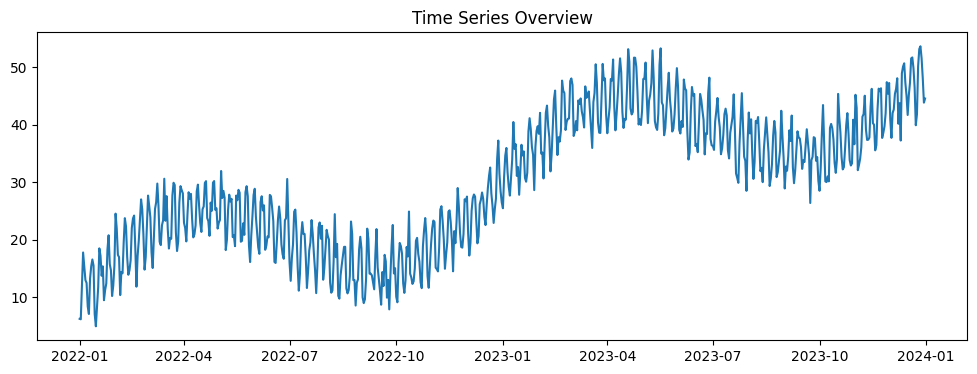

In [21]:
plt.figure(figsize=(12, 4))
plt.plot(series)
plt.title("Time Series Overview")
plt.show()

Key questions:

- Does variance change over time?
- Is there obvious trend or seasonality?
- Are shocks persistent?
- 
# Autocorrelation (ACF)
### Concept

ACF measures correlation between:

> $y_t$ and $y_{t-k}$


High autocorrelation implies strong temporal memory.

## Plot ACF

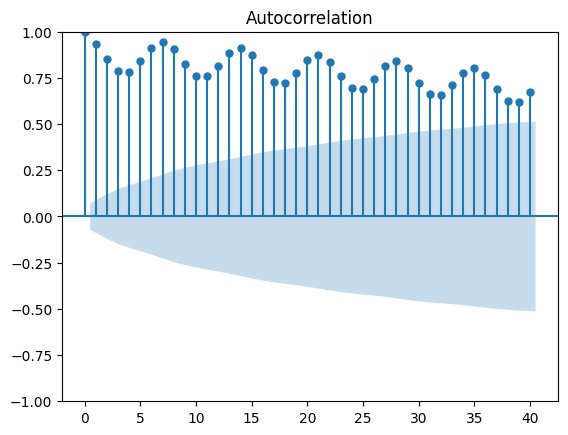

In [24]:
plot_acf(series.dropna(), lags=40)
plt.show()

### Interpretation Guidelines

- Slow decay → non-stationarity
- Seasonal spikes → seasonal structure
- Sharp cutoff → MA behavior
- 
# Partial Autocorrelation (PACF)
## Concept

PACF isolates direct correlation at lag k, removing effects of intermediate lags.

## Plot PACF

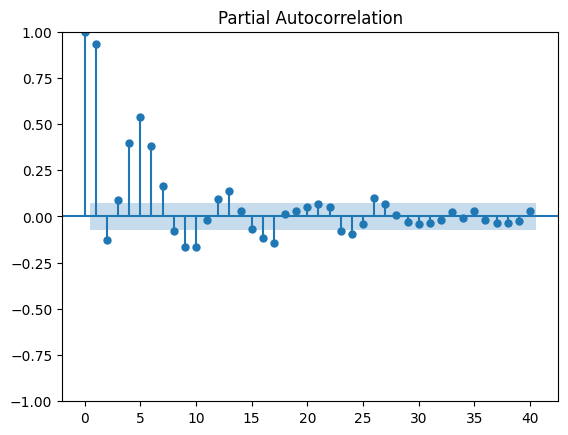

In [28]:
plot_pacf(series.dropna(), lags=40, method="ywm")
plt.show()

### Interpretation Guidelines

- Sharp cutoff → AR behavior
- Seasonal cutoff → seasonal AR
- Long tail → differencing likely required

# Stationarity
## Definition

A stationary series has:

- Constant mean
- Constant variance
- Time-invariant autocorrelation

## Augmented Dickey-Fuller (ADF) Test
### Hypotheses

- **H_₀:** Series is non-stationary

- **H_₁:** Series is stationary

### Run ADF Test

In [31]:
adf_result = adfuller(series.dropna())

adf_output = pd.Series(
    adf_result[0:4],
    index=[
        "ADF Statistic",
        "p-value",
        "Used Lags",
        "Observations"
    ]
)

adf_output

ADF Statistic     -0.858640
p-value            0.801288
Used Lags         18.000000
Observations     711.000000
dtype: float64

In [33]:
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.3f}")

Critical Value (1%): -3.440
Critical Value (5%): -2.866
Critical Value (10%): -2.569


### Interpretation

- p-value < 0.05 → reject H₀ → stationary
- p-value ≥ 0.05 → non-stationary

### Important:
ADF does **not** detect seasonality-induced non-stationarity reliably.

## Differencing
### First Difference

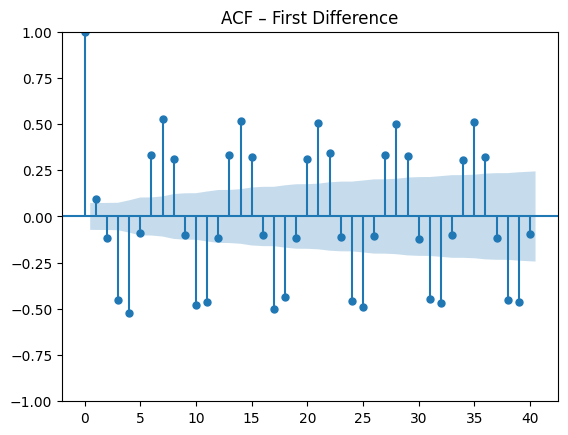

In [36]:
diff_1 = series.diff().dropna()

plot_acf(diff_1, lags=40)
plt.title("ACF – First Difference")
plt.show()

### Seasonal Differencing (If Needed)

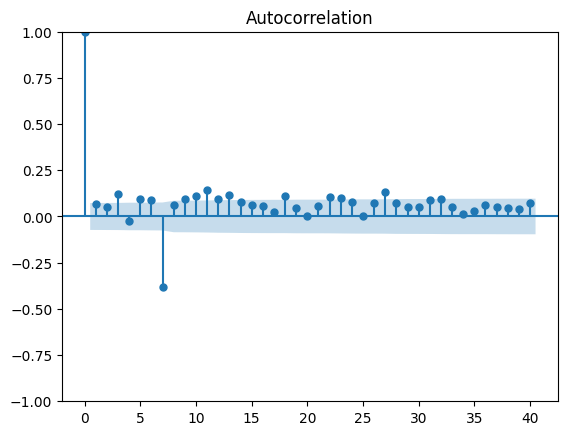

In [40]:
seasonal_diff = series.diff(7).dropna()  # example: weekly seasonality

plot_acf(seasonal_diff, lags=40)
plt.show()

### Before vs After Comparison

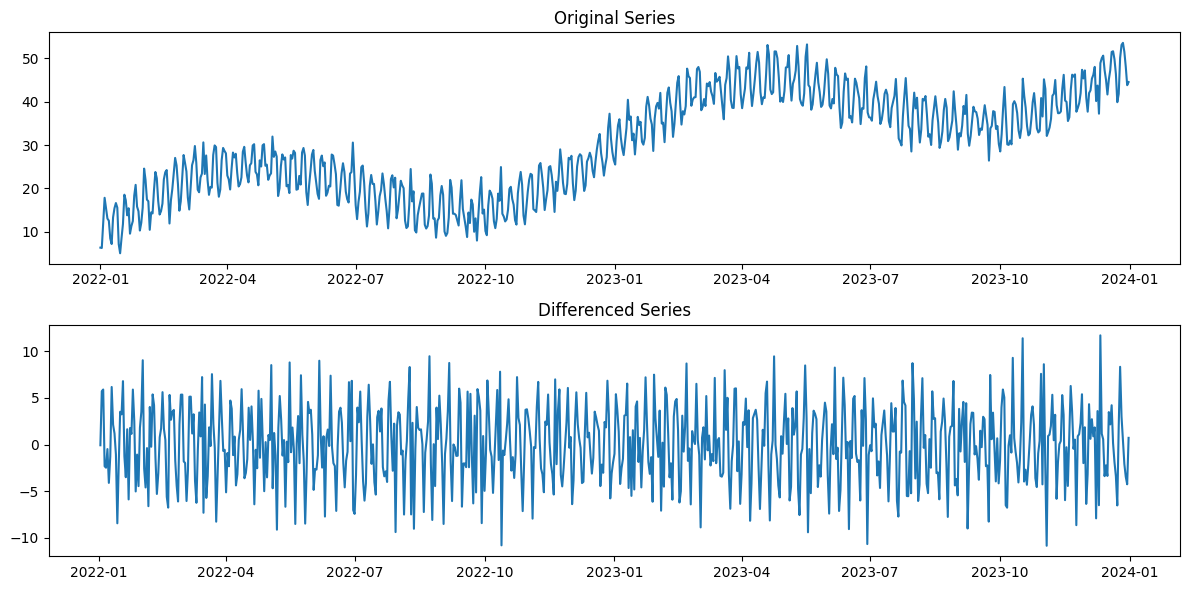

In [43]:
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

ax[0].plot(series)
ax[0].set_title("Original Series")

ax[1].plot(diff_1)
ax[1].set_title("Differenced Series")

plt.tight_layout()
plt.show()

# Practical Modeling Implications

| Observation         | Action                       |
| ------------------- | ---------------------------- |
| Strong trend        | Apply differencing           |
| Seasonal ACF spikes | Seasonal differencing        |
| ACF cutoff          | MA terms                     |
| PACF cutoff         | AR terms                     |
| Long memory         | Consider higher-order models |


# Common Mistakes

- `[cons] - ` Using ACF/PACF on shuffled data
- `[cons] - ` Blindly trusting p-values
- `[cons] - ` Over-differencing
- `[cons] - ` Ignoring seasonal non-stationarity

# How This Feeds the Pipeline


| Stage               | Usage                          |
| ------------------- | ------------------------------ |
| Feature Engineering | Lag and rolling design         |
| Modeling            | ARIMA/SARIMA order selection   |
| Validation          | Horizon-aware splits           |
| Production          | Drift and stability monitoring |


# Key Rule

> Stationarity is a modeling assumption, not a data property.